In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pandasql import sqldf # pip install pandasql

pysqldf = lambda q: sqldf(q, globals())

In [2]:
session_key = 9888

qualificacao_key = 9884

In [3]:
# Carrega os dados das voltas

url_session = f"https://api.openf1.org/v1/laps?session_key={session_key}"
resposta_session = requests.get(url_session)
resposta_session.status_code

if resposta_session.status_code == 200:
  dados_voltas = resposta_session.json()
else:
  print(f"Erro na requisição: {resposta_session.status_code}")

def converter_listas_para_string(dados):
  dados_processados = []

  for i in dados:
      novo_item = i.copy()

      for chave, valor in novo_item.items():
          if isinstance(valor, list):
              novo_item[chave] = str(valor)

      dados_processados.append(novo_item)

  return dados_processados

# Aplicar a conversão
dados_processados = converter_listas_para_string(dados_voltas)
df_voltas = pd.DataFrame(dados_processados)

df_voltas

,meeting_key,session_key,driver_number,lap_number,date_start,duration_sector_1,duration_sector_2,duration_sector_3,i1_speed,i2_speed,is_pit_out_lap,lap_duration,segments_sector_1,segments_sector_2,segments_sector_3,st_speed
0,1271,9888,1,1,None,NaN,39.777,33.041,221.0,178,False,NaN,"[2048, 2049, 2049, 2049, 2051, 2051]","[2051, 2051, 2049, 2051, 2049, 2049, 2049, 2051]","[2051, 2051, 2049, 2049, 2051, 2051, 2051, 2051]",301
1,1271,9888,16,1,None,NaN,40.220,33.272,207.0,175,False,NaN,"[2048, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2051, 2049, 2049, 2051, 2051]",301
2,1271,9888,4,1,None,NaN,40.436,33.432,207.0,178,False,NaN,"[2048, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2051, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2051, 2049, 2049, 2049, 2049, 2049]",303
3,1271,9888,44,1,None,NaN,40.721,33.679,201.0,178,False,NaN,"[2048, 2049, 2051, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2051, 2051]",302
4,1271,9888,81,1,None,NaN,40.876,33.932,197.0,179,False,NaN,"[2048, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 2049]",308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,1271,9888,18,56,2025-10-19T20:37:15.828000+00:00,26.473,39.588,33.389,211.0,185,False,99.450,"[None, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2049, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]",310
1063,1271,9888,12,56,2025-10-19T20:37:17.106000+00:00,26.392,39.430,33.262,223.0,186,False,99.084,"[None, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2049, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]",313
1064,1271,9888,23,56,2025-10-19T20:37:22.047000+00:00,26.200,39.250,33.027,NaN,183,False,98.477,"[None, 2048, 2048, 2048, 2048, 2048]","[2049, 2048, 2048, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]",313
1065,1271,9888,31,56,2025-10-19T20:37:23.817000+00:00,26.353,40.051,33.283,226.0,183,False,99.687,"[2048, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]",307


In [4]:
# Carrega os dados dos pilotos

url_piloto = f"https://api.openf1.org/v1/drivers?session_key={session_key}"
resposta_piloto = requests.get(url_piloto)
resposta_piloto.status_code

if resposta_piloto.status_code == 200:
  dados_piloto = resposta_piloto.json()
else:
  print(f"Erro na requisição: {resposta_piloto.status_code}")

df_piloto = pd.DataFrame(dados_piloto)

df_sigla_piloto = df_piloto[['driver_number', 'name_acronym', 'team_colour']].copy()

# Adicionar # às cores
df_sigla_piloto['team_colour'] = '#' + df_sigla_piloto['team_colour']

df_sigla_piloto

,driver_number,name_acronym,team_colour
0,1,VER,#4781D7
1,4,NOR,#F47600
2,5,BOR,#01C00E
3,6,HAD,#6C98FF
4,10,GAS,#00A1E8
5,12,ANT,#00D7B6
6,14,ALO,#229971
7,16,LEC,#ED1131
8,18,STR,#229971
9,22,TSU,#4781D7


In [5]:
# Carrega os dados de posição de chegada no grid

url_position = f"https://api.openf1.org/v1/session_result?session_key={session_key}"
resposta_position = requests.get(url_position)
resposta_position.status_code

if resposta_position.status_code == 200:
  dados_posicao = resposta_position.json()
else:
  print(f"Erro na requisição: {resposta_position.status_code}")

df_posicao = pd.DataFrame(dados_posicao)

posicao = df_posicao.groupby('driver_number')['position'].last().sort_values()

posicao_final = posicao.sort_values().index.tolist()

mapeamento = dict(zip(df_sigla_piloto['driver_number'], df_sigla_piloto['name_acronym']))

posicao_final_siglas = [mapeamento[piloto_id] for piloto_id in posicao_final]

posicao_final_siglas

['VER',
 'NOR',
 'LEC',
 'HAM',
 'PIA',
 'RUS',
 'TSU',
 'HUL',
 'BEA',
 'ALO',
 'LAW',
 'STR',
 'ANT',
 'ALB',
 'OCO',
 'HAD',
 'COL',
 'BOR',
 'GAS',
 'SAI']

In [6]:
# Carrega os dados de qualificação

url_qualificacao = f"https://api.openf1.org/v1/starting_grid?session_key={qualificacao_key}"
resposta_qualificacao = requests.get(url_qualificacao)
resposta_qualificacao.status_code

if resposta_qualificacao.status_code == 200:
  dados_qualificacao = resposta_qualificacao.json()
else:
  print(f"Erro na requisição: {resposta_qualificacao.status_code}")

df_qualificacao = pd.DataFrame(dados_qualificacao)

df_qualificacao

,position,driver_number,lap_duration,meeting_key,session_key
0,1,1,92.510,1271,9884
1,2,4,92.801,1271,9884
2,3,16,92.807,1271,9884
3,4,63,92.826,1271,9884
4,5,44,92.912,1271,9884
5,6,81,93.084,1271,9884
6,7,12,93.114,1271,9884
7,8,87,93.139,1271,9884
8,9,55,93.150,1271,9884
9,10,14,93.160,1271,9884


In [7]:
# Cria uma estatistica de media de volta de cada piloto

media_tempo_volta = df_voltas.groupby('driver_number')['lap_duration'].mean()

media_tempo_volta

,lap_duration
driver_number,
1,100.726345
4,100.830418
5,102.486241
6,102.216745
10,102.547833
12,102.011600
14,101.862927
16,100.979218
18,101.901418


In [8]:
# Faço o join entre os dados de piloto e os dados de volta no intuito de adicionar a sigla do nome do piloto e a cor da equipe que ele representa

df_merged = df_voltas.merge(df_sigla_piloto, on='driver_number', how='left')

df_merged

,meeting_key,session_key,driver_number,lap_number,date_start,duration_sector_1,duration_sector_2,duration_sector_3,i1_speed,i2_speed,is_pit_out_lap,lap_duration,segments_sector_1,segments_sector_2,segments_sector_3,st_speed,name_acronym,team_colour
0,1271,9888,1,1,None,NaN,39.777,33.041,221.0,178,False,NaN,"[2048, 2049, 2049, 2049, 2051, 2051]","[2051, 2051, 2049, 2051, 2049, 2049, 2049, 2051]","[2051, 2051, 2049, 2049, 2051, 2051, 2051, 2051]",301,VER,#4781D7
1,1271,9888,16,1,None,NaN,40.220,33.272,207.0,175,False,NaN,"[2048, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2051, 2049, 2049, 2051, 2051]",301,LEC,#ED1131
2,1271,9888,4,1,None,NaN,40.436,33.432,207.0,178,False,NaN,"[2048, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2051, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2051, 2049, 2049, 2049, 2049, 2049]",303,NOR,#F47600
3,1271,9888,44,1,None,NaN,40.721,33.679,201.0,178,False,NaN,"[2048, 2049, 2051, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2051, 2051]",302,HAM,#ED1131
4,1271,9888,81,1,None,NaN,40.876,33.932,197.0,179,False,NaN,"[2048, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 2049]",308,PIA,#F47600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,1271,9888,18,56,2025-10-19T20:37:15.828000+00:00,26.473,39.588,33.389,211.0,185,False,99.450,"[None, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2049, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]",310,STR,#229971
1063,1271,9888,12,56,2025-10-19T20:37:17.106000+00:00,26.392,39.430,33.262,223.0,186,False,99.084,"[None, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2049, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]",313,ANT,#00D7B6
1064,1271,9888,23,56,2025-10-19T20:37:22.047000+00:00,26.200,39.250,33.027,NaN,183,False,98.477,"[None, 2048, 2048, 2048, 2048, 2048]","[2049, 2048, 2048, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]",313,ALB,#1868DB
1065,1271,9888,31,56,2025-10-19T20:37:23.817000+00:00,26.353,40.051,33.283,226.0,183,False,99.687,"[2048, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]","[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]",307,OCO,#9C9FA2


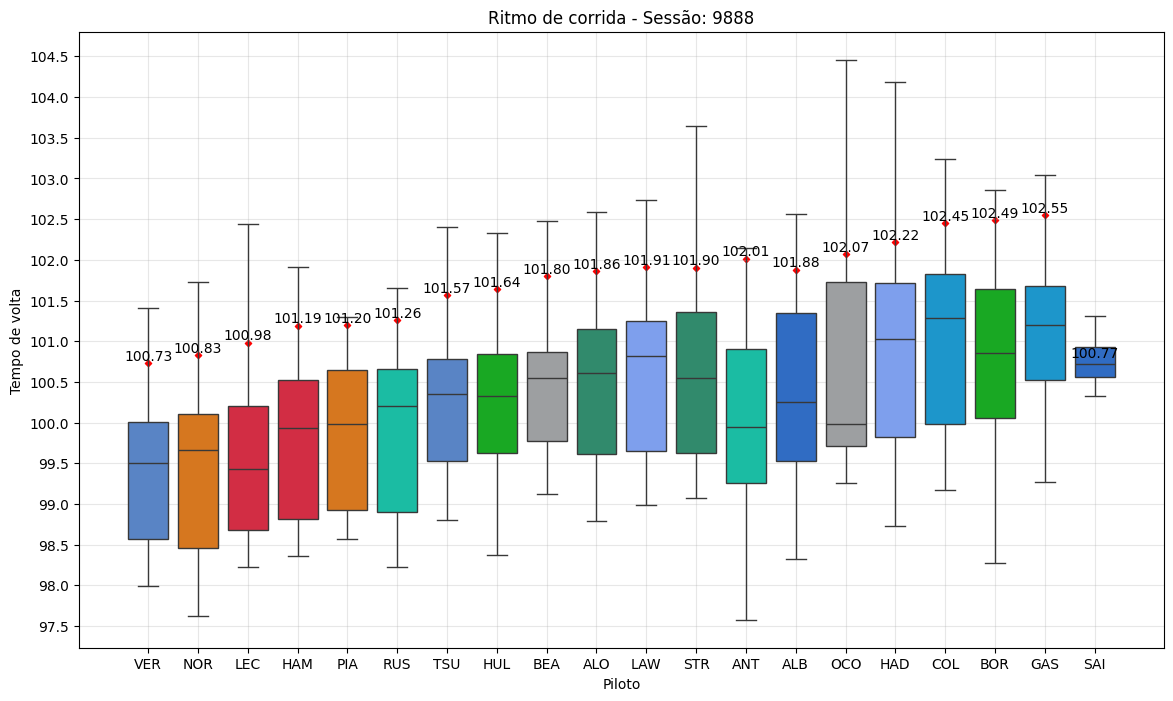

In [9]:
# Cria o gráfico de boxplot com os tempos de volta dos pilotos e a média

plt.figure(figsize=(14, 8))

cores_dict = df_merged.groupby('name_acronym')['team_colour'].first().to_dict()

ax = sns.boxplot(data=df_merged, x='name_acronym', y='lap_duration',
                 order=posicao_final_siglas,
                 showfliers=False,
                 palette=cores_dict,
                 legend=False,
                 hue='name_acronym')

plt.title(f'Ritmo de corrida - Sessão: {session_key}')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta')
plt.grid(True, alpha=0.3)
ax.yaxis.set_major_locator(MultipleLocator(0.5))  # Define intervalos de 0.5

# Média
for i, piloto in enumerate(posicao_final):
    if piloto in media_tempo_volta.index:
        media_piloto = media_tempo_volta[piloto]
        plt.scatter(i, media_piloto, color='red', marker='D', s=10, zorder=1)
        plt.text(i, media_piloto, f'{media_piloto:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

In [10]:
# Crio uma estatistica pra responder qual foi a volta mais rapida de cada piloto

tempo_volta_menor = df_merged.groupby('name_acronym')['lap_duration'].min().sort_values()
tempo_volta_menor

,lap_duration
name_acronym,
ANT,97.577
NOR,97.620
VER,97.991
RUS,98.224
LEC,98.231
BOR,98.275
ALB,98.328
HAM,98.361
HUL,98.372


In [11]:
# Usando SQL eu filtro os 3 pilotos que fizeram a volta mais rápida

consulta_1 = """

with w_menor_tempo_piloto as (
  select
    name_acronym,
    lap_number,
    min(lap_duration) as lap_duration
  from
    df_merged
  group by
    name_acronym
  order by
    lap_duration asc
)
select
  name_acronym as piloto,
  lap_number as num_volta,
  lap_duration as tempo_volta_rapida
from
  w_menor_tempo_piloto
limit
  3

"""

volta_rapida = pysqldf(consulta_1)
volta_rapida

,piloto,num_volta,tempo_volta_rapida
0,ANT,33,97.577
1,NOR,35,97.620
2,VER,35,97.991


In [12]:
# Usando sql eu crio uma tabela que me mostra as posições que os pilotos ganharam ou perderam

consulta_2 = """

with w_qualificacao as (
  select
    driver_number as piloto,
    position as posicao_largada
  from
    df_qualificacao
), w_posicao as (
  select
    driver_number as piloto,
    position as posicao_chegada,
    points as pontos
  from
    df_posicao
), w_sigla_piloto as (
  select
    *
  from
    df_sigla_piloto
)
select
  w3.name_acronym as piloto,
  w1.posicao_largada,
  w2.posicao_chegada,
  case
    when (w1.posicao_largada - w2.posicao_chegada) > 0 then '+' || (w1.posicao_largada - w2.posicao_chegada)
    when (w1.posicao_largada - w2.posicao_chegada) < 0 then '-' || abs(w1.posicao_largada - w2.posicao_chegada)
    else 0
  end as ganho_posicoes,
  cast(w2.pontos as int) as pontos
from
  w_qualificacao w1,
  w_posicao w2,
  w_sigla_piloto w3
where
  w1.piloto = w2.piloto
  and w2.piloto = w3.driver_number

"""

ganho_posicoes = pysqldf(consulta_2)
ganho_posicoes

,piloto,posicao_largada,posicao_chegada,ganho_posicoes,pontos
0,VER,1,1.0,0,25
1,NOR,2,2.0,0,18
2,LEC,3,3.0,0,15
3,RUS,4,6.0,-2.0,8
4,HAM,5,4.0,+1.0,12
5,PIA,6,5.0,+1.0,10
6,ANT,7,13.0,-6.0,0
7,BEA,8,9.0,-1.0,2
8,SAI,9,NaN,0,0
9,ALO,10,10.0,0,1


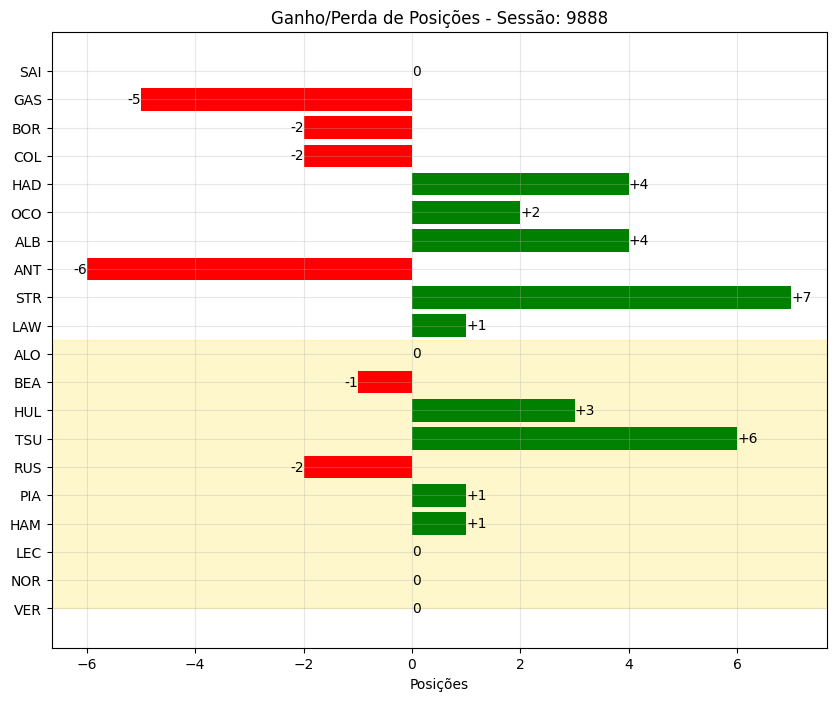

In [13]:
# Gráfico de ganho de posições

# Primeiro, vamos converter a coluna 'ganho_posicoes' para numérico
ganho_posicoes['ganho_posicoes_num'] = ganho_posicoes['ganho_posicoes'].astype(float)

# Ordenar os dados pela posição de chegada
df_sorted = ganho_posicoes.sort_values('posicao_chegada', ascending=True)

# Cria o gráfico
plt.figure(figsize=(10, 8))
plt.axhspan(9.5, 0, alpha=0.2, color='gold') # Criar área de fundo para os 10 primeiros
cores = ['red' if x < 0 else 'green' for x in df_sorted['ganho_posicoes_num']] # Define as cores das barras
bars = plt.barh(df_sorted['piloto'], df_sorted['ganho_posicoes_num'], color=cores) # Define as barras
plt.xlabel('Posições')
plt.title(f'Ganho/Perda de Posições - Sessão: {session_key}')
plt.grid(True, alpha=0.3, )

# Adicionar os valores nas barras
for bar, valor in zip(bars, df_sorted['ganho_posicoes_num']):
    if valor is not None:
      plt.text(bar.get_width(),
              bar.get_y() + bar.get_height()/2,
              f'{valor:+.0f}' if valor != 0 else f'{valor:.0f}',
              ha='left' if valor >= 0 else 'right',
              va='center')

plt.show()